# Estimating Turnover in Retail Trade

### Capstone Project by Christian Furger 

The Retail Trade Turnover Statistics (DHU) is a monthly economic statistic by the Federal Statistical Office (FSO) describing the evolution of turnover in retail trade at the national level. The survey population comprises all enterprises active in retail trade which are domiciled in Switzerland. Large and medium enterprises are surveyed exhaustively, small enterprises are surveyed randomly. The sample consists of around 4000 enterprises. Large enterprises are surveyed each month, the others four times per year, when monthly data are collected. To be able to publish representative results every month, data for three months are collected with one questionnaire for small and medium enterprises, but shifted by zero, one or two month for the three sub-samples. More information can be found on the FSO website: www.dhu.bfs.admin.ch

#### Goal of this project
At the time of the calculation of the results, not all enterprises have responded to the survey. Furthermore, the data users wish first estimations even earlier. Therefore, the goal of this project is to find methods to estimate the turnover of a given enterprise for a given month by using the information available from other respondents and the past.

## Data Preparation

### (a) Clear overview of your data

The data for this project come from the production environment of the retail trade turnover statistics and are highly sensitive. Therefore, when showing individual datalines, I make sure to only show small enterprises, which can't be identified.

The main tables are:
* Admin_Data: information about the enterprises of the survey
* Resp_Final: validated monthly responses of theses enterprises.

The datasets contain information from January 2014 to December 2020.

In [1]:
# Import statements
import os
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#### Admin_Data
Administrative data of enterprises

##### Variables:
* OID: ID of enterprise
* KT: Canton of enterprise (location)
* ZIP: Zip Code of enterprise (location)
* Lang: Language of correspondence (1=German; 2=French; 3=Italian)
* Stratum_Noga/Stratum_Size: information regarding the stratification of the sample by activity (Noga) and size of the enterprise (1=small; 2=medium; 3=large)
* Empl_Enterprise/FTE_Enterprise: employment/full time equivalents of the enterprise as a whole
* Empl_RT: employment of the enterprise in retail trade
* Profiling (Flag): 1 if enterprise is part of Profiling (special relation between FSO and important/big/complex enterprises)
* Sample_ID: sub-sample (M=monthly survey; Q1=quarterly survey ending first month of quarter; Q2=quarterly survey ending second month of quarter; Q3=quarterly survey ending third month of quarter)
* Noga_Enterprise: classification of main activity of enterprise
* Hist_Limit: Beginning of time series (2014Jan or 2018Jan)
* Sample_1/Sample_2 (Flag): Indication, to which sample the enterprise belongs (Sample_1: 2014Jan-2018Dec; Sample_2: 2018Jan-now). Big enterprises belong to both samples.
* Resp (Flag): Indication, if enterprise has responses

In [2]:
#Importing Admin_Total
admin_data = pd.read_csv('Admin_Data.csv',  dtype = {'Stratum_Noga' : object, 'Stratum_Size' : object, 'Noga_Enterprise' : object, 'Hist_Limit' : object})
admin_data.shape

(6299, 16)

In [3]:
admin_data.head()

,OID,KT,ZIP,Lang,Stratum_Noga,Empl_Enterprise,Stratum_Size,FTE_Enterprise,Profiling,Sample_ID,Noga_Enterprise,Hist_Limit,Empl_RT,Sample_1,Sample_2,Resp
0,1001536,TI,6596,3,475,1,1,0.98,0,Q1,4752,201801,1.0,0,1,0
1,1002489,LU,6004,1,477,6,1,5.25,0,Q3,4778,201401,6.0,1,0,0
2,1002813,TI,6830,3,476,3,1,2.30,0,Q2,4761,201401,3.0,1,0,0
3,1004201,GE,1227,2,476,264,1,14.00,0,M,4649,201401,14.0,1,0,0
4,1005483,ZH,8048,1,476,3,1,2.14,0,Q2,4765,201401,3.0,1,0,0


In [4]:
# missing data
admin_data.isnull().sum()

OID                 0
KT                 76
ZIP                 0
Lang                0
Stratum_Noga        2
Empl_Enterprise     0
Stratum_Size        2
FTE_Enterprise      0
Profiling           0
Sample_ID           1
Noga_Enterprise     2
Hist_Limit          0
Empl_RT             9
Sample_1            0
Sample_2            0
Resp                0
dtype: int64

Missing data for the variable 'KT' means that the enterprise can't be attributed to one canton alone and will therefore be imputed with 'CH'.

In [5]:
admin_data.KT.fillna('CH', inplace=True)
admin_data[admin_data.isnull().any(axis=1)]

,OID,KT,ZIP,Lang,Stratum_Noga,Empl_Enterprise,Stratum_Size,FTE_Enterprise,Profiling,Sample_ID,Noga_Enterprise,Hist_Limit,Empl_RT,Sample_1,Sample_2,Resp
802,2171475,CH,8032,1,473,35,2,21.614777,0,Q3,4730,201401,NaN,1,0,0
1101,2587218,CH,1659,2,477,54,3,44.416348,0,M,4771,201401,NaN,1,0,1
3416,5962266,CH,8500,1,NaN,190,NaN,121.250000,0,M,NaN,201401,135.0,1,1,1
3465,6031648,CH,8001,1,477,678,3,516.580200,1,M,4771,201401,NaN,1,1,1
3760,6424568,CH,8422,1,473,35,2,21.614777,0,Q3,4730,201401,NaN,1,0,0
4151,6996499,CH,1950,2,NaN,288,NaN,107.000000,0,M,NaN,201401,157.0,1,0,1
4651,7704098,CH,1659,1,477,54,3,44.416401,0,NaN,4771,201401,NaN,1,0,0
4826,7930285,CH,1680,2,4711.472,15,2,8.789172,0,Q3,4724,201401,NaN,1,0,1
5599,9027266,CH,8304,1,473,35,2,21.614777,0,Q3,4730,201401,NaN,1,0,0
5824,9336927,CH,1950,2,477,54,3,44.416348,0,M,4771,201401,NaN,1,0,0


Missing data for the variables 'Stratum_Noga', 'Stratum_Size', 'Noga_Enterprise' and 'Empl_RT' will be treated in the preprocessing steps of the machine learning part.

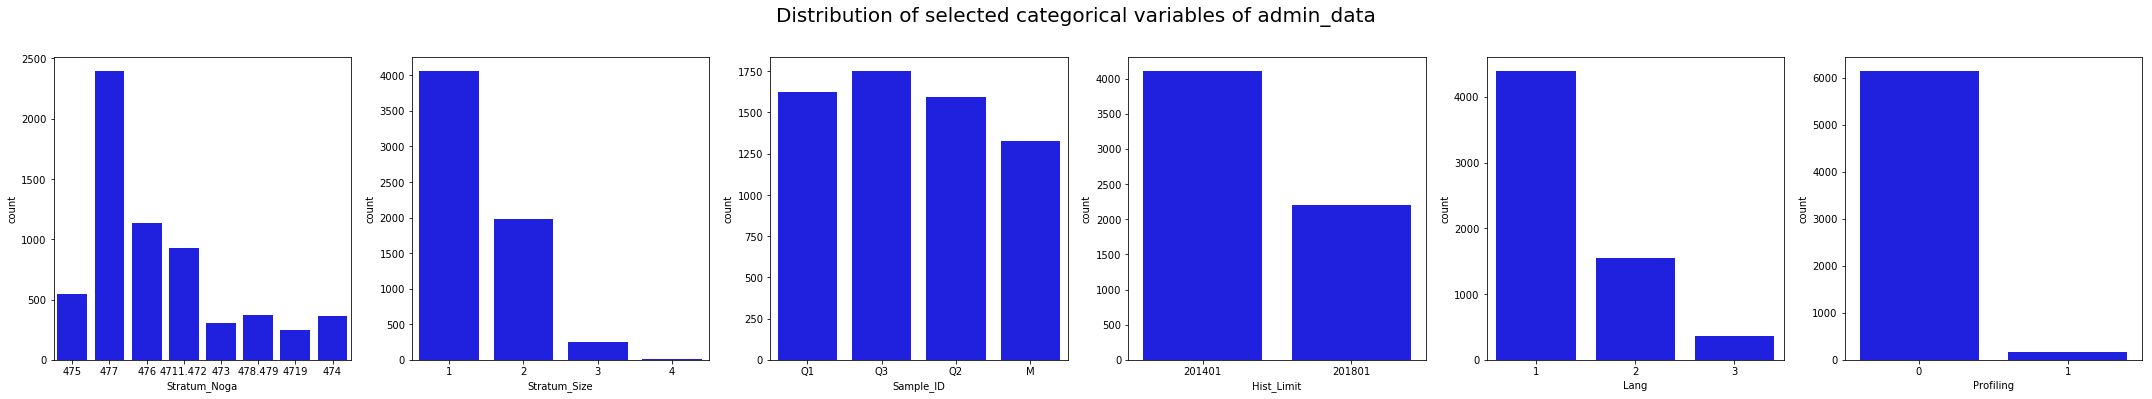

In [6]:
# Distribution of some variables of admin_data
admin_cat=['Stratum_Noga','Stratum_Size','Sample_ID','Hist_Limit','Lang','Profiling']

fig, axs = plt.subplots(1,len(admin_cat),figsize=(5*len(admin_cat),5))

for i in range (0,len(admin_cat)):
    sns.catplot(x=admin_cat[i], kind ='count', color='blue', data=admin_data, ax=axs[i])
    plt.close()

fig.suptitle("Distribution of selected categorical variables of admin_data",fontsize=20, y=1.1);
fig.tight_layout()

In the first sample (2014-2018) there were 4 size strata, in the second (2018-2020) only 3. For coherence reasons, stratum 4 is merged with stratum 3.

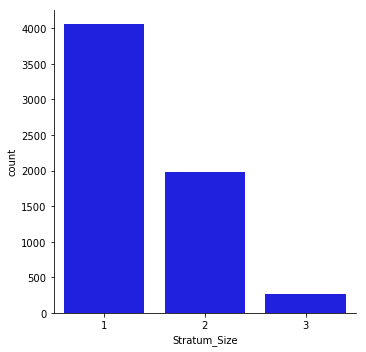

In [7]:
admin_data.loc[admin_data['Stratum_Size']=='4', 'Stratum_Size']='3'

sns.catplot(x='Stratum_Size', kind='count', color='blue', data=admin_data);

#### Final_Resp
Monthly responses used for calculation of the retail trade turnover statistics

##### Variables:
* OID: ID of enterprise
* Period: Survey month
* Channel_ID: Channel of participation (1=Paper questionnaire; 2=Online survey; 5=manual entry)
* Resp_Status: Status of the response (8=received; 9=not valid; 10=valid; 11=valid Group)
* DateStatus8-11: Datetime of the corresponding status of the response
* VAT: Turnover of enterprise according to VAT information at the time of drawing of sample (stable during life of sample_1/sample_2)
* Group/SentBy: Information regarding groups of enterprises
* Split/SentFor: Information regarding splits of enterprises
* UTOT: Final monthly turnover of enterprise used for calculation of results
* UFOOD/UBEKL/UTREIB/UNFOOD: Monthly turnover for different product groups (Food/Clothing/Fuel/Other)
* nb_modif: number of modifications of UTOT from reception until validation

In [8]:
#Importing Resp_Final
resp_final=pd.read_csv('Resp_Final.csv', low_memory=False, dtype={'Period' : object, 'Channel_ID' : object})
resp_final.shape

(197148, 19)

In [9]:
resp_final.head()

,OID,Period,Channel_ID,Resp_Status,DateStatus8,DateStatus9,DateStatus10,DateStatus11,VAT,Group,SentBy,Split,SentFor,UFOOD,UBEKL,UTREIB,UNFOOD,UTOT,nb_modif
0,1005620,201401,2,10,20JUL2015:11:01:21.733,20JUL2015:16:04:37.000,20JUL2015:16:06:17.000,NaN,641.0,0,NaN,0,NaN,14,0,0,505,519,1
1,1005620,201402,2,10,20JUL2015:11:01:21.733,NaN,20JUL2015:16:07:58.000,NaN,641.0,0,NaN,0,NaN,15,0,0,508,523,1
2,1005620,201403,2,10,20JUL2015:11:01:21.730,20JUL2015:16:10:53.000,20JUL2015:16:15:20.000,NaN,641.0,0,NaN,0,NaN,15,0,0,585,600,1
3,1005620,201404,2,10,13JUL2015:13:01:35.883,16JUL2015:16:16:10.000,16JUL2015:16:16:56.000,NaN,641.0,0,NaN,0,NaN,11,0,0,549,560,1
4,1005620,201405,2,10,13JUL2015:13:01:35.697,14JUL2015:08:25:49.000,16JUL2015:16:17:05.000,NaN,641.0,0,NaN,0,NaN,8,0,0,574,582,1


In [10]:
# Missing data
resp_final.isnull().sum()

OID                  0
Period               0
Channel_ID          80
Resp_Status          0
DateStatus8         59
DateStatus9     105613
DateStatus10      2898
DateStatus11    194250
VAT                630
Group                0
SentBy          194250
Split                0
SentFor         196780
UFOOD                0
UBEKL                0
UTREIB               0
UNFOOD               0
UTOT                 0
nb_modif             0
dtype: int64

Missing data for the Date variables logical, because these variables exist only, if a response has passed a certain status. If the response is validated (our case), it has either a value for 'DateStatus10' or for 'DateStatus11'. The sum of the missings for those two variables is 197148, which corresponds to the number of all entries in the dataset.

The variable 'SentBy' is empty for all entries with Group=0; the variable 'SentFor' is empty for all entries with Split=0.

"Real" missing values exist only for the variables 'Channel_ID' and 'VAT'. These will be treated in the prepocessing steps.

In [11]:
resp_final.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
OID,197148.0,5526355.35,2571345.71,1005620.0,3352189.0,5527690.0,7746441.0,9999019.0
Resp_Status,197148.0,10.01,0.12,10.0,10.0,10.0,10.0,11.0
VAT,196518.0,2058.94,25765.89,0.0,71.0,211.0,586.0,884045.0
Group,197148.0,0.01,0.12,0.0,0.0,0.0,0.0,1.0
SentBy,2898.0,5580193.01,2485313.45,1152676.0,2843418.0,5942315.0,7616523.0,9805481.0
Split,197148.0,0.00,0.04,0.0,0.0,0.0,0.0,1.0
SentFor,368.0,5768522.62,1648001.73,2237309.0,4962261.0,5717974.0,8035914.0,8035914.0
UFOOD,197148.0,1144.89,23798.98,0.0,0.0,0.0,17.0,1158084.0
UBEKL,197148.0,299.33,2624.67,0.0,0.0,0.0,0.0,110218.0
UTREIB,197148.0,128.56,2607.10,0.0,0.0,0.0,0.0,157343.0


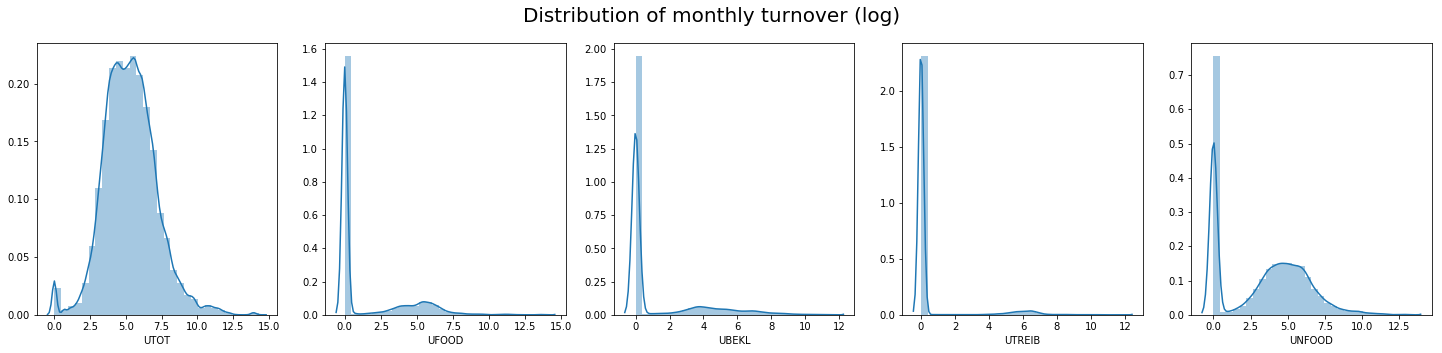

In [12]:
# Distribution of monthly turnover
fig, axs = plt.subplots(1,5,figsize=(25,5))

sns.distplot(np.log1p(resp_final['UTOT']), kde=True, bins=30, ax=axs[0])
sns.distplot(np.log1p(resp_final['UFOOD']), kde=True, bins=30, ax=axs[1])
sns.distplot(np.log1p(resp_final['UBEKL']), kde=True, bins=30, ax=axs[2])
sns.distplot(np.log1p(resp_final['UTREIB']), kde=True, bins=30, ax=axs[3])
sns.distplot(np.log1p(resp_final['UNFOOD']), kde=True, bins=30, ax=axs[4])
plt.suptitle('Distribution of monthly turnover (log)', fontsize=20);

The turnover per product group ('UFOOD','UBEKL','UTREIB' and 'UNFOOD') is only used for illustrative purposes and will therefore be dropped. For coherence reasons, the target variable 'UTOT' (Umsatz Total) is renamed to 'TOV' (Turnover).

In [13]:
resp_final.drop(['UFOOD','UBEKL','UTREIB','UNFOOD'], axis=1, inplace=True)
resp_final.rename(columns={"UTOT":"TOV"}, inplace=True)
resp_final.head()

,OID,Period,Channel_ID,Resp_Status,DateStatus8,DateStatus9,DateStatus10,DateStatus11,VAT,Group,SentBy,Split,SentFor,TOV,nb_modif
0,1005620,201401,2,10,20JUL2015:11:01:21.733,20JUL2015:16:04:37.000,20JUL2015:16:06:17.000,NaN,641.0,0,NaN,0,NaN,519,1
1,1005620,201402,2,10,20JUL2015:11:01:21.733,NaN,20JUL2015:16:07:58.000,NaN,641.0,0,NaN,0,NaN,523,1
2,1005620,201403,2,10,20JUL2015:11:01:21.730,20JUL2015:16:10:53.000,20JUL2015:16:15:20.000,NaN,641.0,0,NaN,0,NaN,600,1
3,1005620,201404,2,10,13JUL2015:13:01:35.883,16JUL2015:16:16:10.000,16JUL2015:16:16:56.000,NaN,641.0,0,NaN,0,NaN,560,1
4,1005620,201405,2,10,13JUL2015:13:01:35.697,14JUL2015:08:25:49.000,16JUL2015:16:17:05.000,NaN,641.0,0,NaN,0,NaN,582,1


### (b) Plan to manage and process the data

As the data come from an active production environment, they have already been cleaned by that system. The data we see in 'Resp_Final' are the responses used for calculating the final results of the statistics. To be able to work also with raw data as it enters the production environment, I also work with the log files.

For the exploratory data analysis, the tables 'admin_data' and 'resp_final' are merged to obtain a dataset containing all relevant variables. This creates a dataset containing one row per enterprise and month. The target variable is 'TOV'. As the turnover data have a seasonal pattern (e.g. higher turnover for christmas), different lags are calculated as features (e.g. t-1, t-12).

In [14]:
# Combining 'admin_data' and 'resp_final'
resp_DHU=pd.merge(admin_data, resp_final, how='inner')
resp_DHU.tail(10)

,OID,KT,ZIP,Lang,Stratum_Noga,Empl_Enterprise,Stratum_Size,FTE_Enterprise,Profiling,Sample_ID,...,DateStatus9,DateStatus10,DateStatus11,VAT,Group,SentBy,Split,SentFor,TOV,nb_modif
197138,9999019,BL,4434,1,477,5,1,2.54,0,Q3,...,16JUN2020:12:26:14.937,16JUN2020:12:26:45.220,NaN,39.0,0,NaN,0,NaN,15,1
197139,9999019,BL,4434,1,477,5,1,2.54,0,Q3,...,26JUN2020:07:32:27.307,06JUL2020:10:49:34.370,NaN,39.0,0,NaN,0,NaN,8,1
197140,9999019,BL,4434,1,477,5,1,2.54,0,Q3,...,26JUN2020:07:33:57.950,06JUL2020:10:50:20.337,NaN,39.0,0,NaN,0,NaN,120,1
197141,9999019,BL,4434,1,477,5,1,2.54,0,Q3,...,26JUN2020:07:35:34.497,06JUL2020:10:51:17.743,NaN,39.0,0,NaN,0,NaN,25,1
197142,9999019,BL,4434,1,477,5,1,2.54,0,Q3,...,08DEC2020:07:38:29.447,09MAR2021:10:30:42.897,NaN,39.0,0,NaN,0,NaN,25,1
197143,9999019,BL,4434,1,477,5,1,2.54,0,Q3,...,NaN,08DEC2020:07:39:16.587,NaN,39.0,0,NaN,0,NaN,27,1
197144,9999019,BL,4434,1,477,5,1,2.54,0,Q3,...,NaN,08DEC2020:07:40:53.713,NaN,39.0,0,NaN,0,NaN,39,1
197145,9999019,BL,4434,1,477,5,1,2.54,0,Q3,...,NaN,13JAN2021:07:30:37.287,NaN,39.0,0,NaN,0,NaN,25,1
197146,9999019,BL,4434,1,477,5,1,2.54,0,Q3,...,13JAN2021:07:31:37.130,09MAR2021:10:31:22.897,NaN,39.0,0,NaN,0,NaN,27,1
197147,9999019,BL,4434,1,477,5,1,2.54,0,Q3,...,NaN,13JAN2021:07:33:45.463,NaN,39.0,0,NaN,0,NaN,31,1


In [15]:
# Adding date, year and month
resp_DHU['Date'] = pd.DatetimeIndex(pd.to_datetime(resp_DHU['Period'], format='%Y%m')).to_period('M') 
resp_DHU['Year']=resp_DHU['Period'].str[0:4]
resp_DHU['Month']=resp_DHU['Period'].str[4:6]
resp_DHU.head()

,OID,KT,ZIP,Lang,Stratum_Noga,Empl_Enterprise,Stratum_Size,FTE_Enterprise,Profiling,Sample_ID,...,VAT,Group,SentBy,Split,SentFor,TOV,nb_modif,Date,Year,Month
0,1005620,GE,1212,2,477,32,2,25.969999,0,Q3,...,641.0,0,NaN,0,NaN,519,1,2014-01,2014,01
1,1005620,GE,1212,2,477,32,2,25.969999,0,Q3,...,641.0,0,NaN,0,NaN,523,1,2014-02,2014,02
2,1005620,GE,1212,2,477,32,2,25.969999,0,Q3,...,641.0,0,NaN,0,NaN,600,1,2014-03,2014,03
3,1005620,GE,1212,2,477,32,2,25.969999,0,Q3,...,641.0,0,NaN,0,NaN,560,1,2014-04,2014,04
4,1005620,GE,1212,2,477,32,2,25.969999,0,Q3,...,641.0,0,NaN,0,NaN,582,1,2014-05,2014,05


Adding flag for the lockdown during the coronavirus pandemic: March 2020 - Mai 2020

In [16]:
# Dummy for lockdown during the coronavirus pandemic
lockdown_start='2020-03'
lockdown_end='2020-05'

resp_DHU.loc[((resp_DHU['Date']<lockdown_start) | (resp_DHU['Date']>lockdown_end)), ('Lockdown')] = 0
resp_DHU.loc[((resp_DHU['Date']>=lockdown_start) & (resp_DHU['Date']<=lockdown_end)), ('Lockdown')] = 1
resp_DHU.tail(12)

,OID,KT,ZIP,Lang,Stratum_Noga,Empl_Enterprise,Stratum_Size,FTE_Enterprise,Profiling,Sample_ID,...,Group,SentBy,Split,SentFor,TOV,nb_modif,Date,Year,Month,Lockdown
197136,9999019,BL,4434,1,477,5,1,2.54,0,Q3,...,0,NaN,0,NaN,0,0,2020-01,2020,01,0.0
197137,9999019,BL,4434,1,477,5,1,2.54,0,Q3,...,0,NaN,0,NaN,0,0,2020-02,2020,02,0.0
197138,9999019,BL,4434,1,477,5,1,2.54,0,Q3,...,0,NaN,0,NaN,15,1,2020-03,2020,03,1.0
197139,9999019,BL,4434,1,477,5,1,2.54,0,Q3,...,0,NaN,0,NaN,8,1,2020-04,2020,04,1.0
197140,9999019,BL,4434,1,477,5,1,2.54,0,Q3,...,0,NaN,0,NaN,120,1,2020-05,2020,05,1.0
197141,9999019,BL,4434,1,477,5,1,2.54,0,Q3,...,0,NaN,0,NaN,25,1,2020-06,2020,06,0.0
197142,9999019,BL,4434,1,477,5,1,2.54,0,Q3,...,0,NaN,0,NaN,25,1,2020-07,2020,07,0.0
197143,9999019,BL,4434,1,477,5,1,2.54,0,Q3,...,0,NaN,0,NaN,27,1,2020-08,2020,08,0.0
197144,9999019,BL,4434,1,477,5,1,2.54,0,Q3,...,0,NaN,0,NaN,39,1,2020-09,2020,09,0.0
197145,9999019,BL,4434,1,477,5,1,2.54,0,Q3,...,0,NaN,0,NaN,25,1,2020-10,2020,10,0.0


Creating features from turnover: t-1, t-2, t-12

In [17]:
# Calculating lags: t-1, t-2, t-12
df_compl=resp_DHU
resp_lag=resp_DHU[['OID','Date','TOV']].set_index(['Date', 'OID']) # index

lag=(1,2,12)
for i in lag:
    lag_t=resp_lag.unstack().shift(i)
    lag_t=lag_t.stack(dropna=False)  # pull out the groups, shift with lag    
    lag_t=lag_t.sort_values(by=['OID','Date']).reset_index()
    lag_t=lag_t.rename(columns={'TOV': 'TOV_lag{}'.format(i)})
    df_compl=pd.merge(df_compl, lag_t, how='inner')
    
df_compl.head(20)

,OID,KT,ZIP,Lang,Stratum_Noga,Empl_Enterprise,Stratum_Size,FTE_Enterprise,Profiling,Sample_ID,...,SentFor,TOV,nb_modif,Date,Year,Month,Lockdown,TOV_lag1,TOV_lag2,TOV_lag12
0,1005620,GE,1212,2,477,32,2,25.969999,0,Q3,...,NaN,519,1,2014-01,2014,01,0.0,NaN,NaN,NaN
1,1005620,GE,1212,2,477,32,2,25.969999,0,Q3,...,NaN,523,1,2014-02,2014,02,0.0,519.0,NaN,NaN
2,1005620,GE,1212,2,477,32,2,25.969999,0,Q3,...,NaN,600,1,2014-03,2014,03,0.0,523.0,519.0,NaN
3,1005620,GE,1212,2,477,32,2,25.969999,0,Q3,...,NaN,560,1,2014-04,2014,04,0.0,600.0,523.0,NaN
4,1005620,GE,1212,2,477,32,2,25.969999,0,Q3,...,NaN,582,1,2014-05,2014,05,0.0,560.0,600.0,NaN
5,1005620,GE,1212,2,477,32,2,25.969999,0,Q3,...,NaN,631,1,2014-06,2014,06,0.0,582.0,560.0,NaN
6,1005620,GE,1212,2,477,32,2,25.969999,0,Q3,...,NaN,523,1,2014-07,2014,07,0.0,631.0,582.0,NaN
7,1005620,GE,1212,2,477,32,2,25.969999,0,Q3,...,NaN,439,1,2014-08,2014,08,0.0,523.0,631.0,NaN
8,1005620,GE,1212,2,477,32,2,25.969999,0,Q3,...,NaN,561,1,2014-09,2014,09,0.0,439.0,523.0,NaN
9,1005620,GE,1212,2,477,32,2,25.969999,0,Q3,...,NaN,592,1,2014-10,2014,10,0.0,561.0,439.0,NaN


In [18]:
df_compl.shape

(197148, 37)

In [19]:
# Dropping entries without lagged turnover
df_clean=df_compl.dropna(subset=['TOV_lag1','TOV_lag2','TOV_lag12']).copy()
df_clean.shape

(143933, 37)

In [20]:
df_clean.isnull().sum()

OID                     0
KT                      0
ZIP                     0
Lang                    0
Stratum_Noga           75
Empl_Enterprise         0
Stratum_Size           75
FTE_Enterprise          0
Profiling               0
Sample_ID               0
Noga_Enterprise        75
Hist_Limit              0
Empl_RT               104
Sample_1                0
Sample_2                0
Resp                    0
Period                  0
Channel_ID             49
Resp_Status             0
DateStatus8            39
DateStatus9         79336
DateStatus10         2251
DateStatus11       141682
VAT                   486
Group                   0
SentBy             141682
Split                   0
SentFor            143723
TOV                     0
nb_modif                0
Date                    0
Year                    0
Month                   0
Lockdown                0
TOV_lag1                0
TOV_lag2                0
TOV_lag12               0
dtype: int64

Missing data for the Date variables logical, because these variables exist only, if a response has passed a certain status. If the response is validated (our case), it has either a value for 'DateStatus10' or for 'DateStatus11'. The sum of the missings for those two variables is 143933, which corresponds to the number of all entries in the dataset.

The variable 'SentBy' is empty for all entries with Group=0; the variable 'SentFor' is empty for all entries with Split=0.

"Real" missing values exist only for the variables 'Stratum_Noga', 'Stratum_Size', 'Noga_Enterprise', 'Empl_RT', 'Channel_ID' and 'VAT'. These will be treated in the prepocessing steps.

All categorical variables have to be One-Hot encoded before they can be used for the machine learning task.

In [21]:
# Exporting final datasets for next steps
# Admin_Data
admin_data.to_csv("admin_data_prep.csv", encoding='utf-8', index=False)
# Responses
df_clean.to_csv("resp_data_prep.csv", encoding='utf-8', index=False)